# Parameters learning for DBN student modeling 

In [1]:
import sys

sys.path.append("/home/olivier/PycharmProjects/bayesian-kst/")

import numpy as np
from kgraph.expert_layer.domain_graph import DomainGraph
from kgraph.expert_layer.knowledge_components import KnowledgeComponent, ProceduralKnowledgeComponent
from kgraph.expert_layer.links import LinkModel, LinkFromParents, LinkFromChildren
from kgraph.resources_layer.exercise_family import ExerciseFamily
from kgraph.resources_layer.exercise import Exercise
from kgraph.learner_layer.evaluation import Evaluation
from kgraph.learner_layer.learner_pool import LearnerPool
from kgraph.learner_layer.learner import Learner, LearnerGraph
from kgraph.helpers.truthtable import truthtable
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

## A. Simulation of KCs, exercices, students and learner traces

### 1. Knowledge components and prerequisite links

In [2]:
# we define the KCs
KC_A = ProceduralKnowledgeComponent(1, "A")
KC_B = ProceduralKnowledgeComponent(2, "B")
KC_C = ProceduralKnowledgeComponent(3, "C")

P_C_knowing_A_and_B = np.array([[1., 0.],
                                [.85, .15],
                                [.9, .1],
                                [.4, .6]])


# we define the link between the two that gonna lead to the link model
link_a_to_b = LinkFromParents(KC_B, [KC_A], [.4, .6])
link_b_to_a = LinkFromChildren(KC_A, [KC_B], [.1, .9])
link_model = LinkModel([LinkFromParents(KC_C, [KC_A, KC_B], P_C_knowing_A_and_B.flatten().tolist())])
# we create the associated domain graph
domain_graph = DomainGraph([KC_A, KC_B, KC_C], link_model)
knowledge_components = domain_graph.get_knowledge_components()

### 2. Exercises and exercise families

In [3]:
# default params
params = {"slip": .1, "guess":.25}

# we define the exercises that corresponds to KC_A
ex_A_1 = Exercise(1, "qcm", ex_content="", params=params)
ex_A_2 = Exercise(2, "qcm", ex_content="", params=params)
ex_A_3 = Exercise(3, "qcm", ex_content="", params=params)
ex_A_4 = Exercise(4, "qcm", ex_content="", params=params)
ex_A_5 = Exercise(5, "qcm", ex_content="", params=params)

ex_fam_A = ExerciseFamily(1, "ex_fam_A", KC_A, [ex_A_1, ex_A_2, ex_A_3, ex_A_4, ex_A_5])

# we define the exercises that corresponds to KC_A
ex_B_1 = Exercise(6, "qcm", ex_content="", params=params)
ex_B_2 = Exercise(7, "qcm", ex_content="", params=params)
ex_B_3 = Exercise(8, "qcm", ex_content="", params=params)
ex_B_4 = Exercise(9, "qcm", ex_content="", params=params)
ex_B_5 = Exercise(10, "qcm", ex_content="", params=params)

ex_fam_B = ExerciseFamily(1, "ex_fam_B", KC_B, [ex_B_1, ex_B_2, ex_B_3, ex_B_4, ex_B_5])


# we define the exercises that corresponds to KC_C
ex_C_1 = Exercise(11, "qcm", ex_content="", params=params)
ex_C_2 = Exercise(12, "qcm", ex_content="", params=params)
ex_C_3 = Exercise(13, "qcm", ex_content="", params=params)
ex_C_4 = Exercise(14, "qcm", ex_content="", params=params)
ex_C_5 = Exercise(15, "qcm", ex_content="", params=params)

ex_fam_B = ExerciseFamily(1, "ex_fam_B", KC_C, [ex_C_1, ex_C_2, ex_C_3, ex_C_4, ex_C_5])


### 3. Students

In [4]:
learner_pool = LearnerPool(domain_graph)
learner_pool.setup_random_learners(1000)

### 4. Learner traces on exercises

In [5]:
n_evals = 3000
sim_evaluations = learner_pool.simulate_evaluations_from_learners(n_evals)

In [ ]:
def sim_evals_2_dataframe(sim_evals):
    
    
    # the columns of the dataframe must coincide with : # 	Student 	Problem 	Step 	Attempt # 	Student Input 	Evaluation 	Knowledge component
    
    
    
    
    
    return df

## B. Parameters learning for BN0

### 1. Preparation of the dataset given the simulated traces

In [6]:
temp_eval = []
for i in range(len(sim_evaluations)):
    temp = []
    for evaluation in sim_evaluations[i]:
        temp += [(evaluation.get_kc(), int(evaluation.answers[key]["success"])) for key in list(evaluation.answers.keys())]
    temp_eval.append(temp)

In [7]:
import pandas as pd
col_names = [[f"{kc.name}_0", f"eval{kc.name}_0"] for kc in knowledge_components]
col_names = [element for li in col_names for element in li]


n_rows = sum([1 if sim_evaluations[learner_idx] else 0 for learner_idx in range(len(temp_eval))])

data = pd.DataFrame([["?" for _ in range(len(col_names))] for _ in range(n_rows)], columns=col_names)

df_idx = 0
for learner_idx in range(len(temp_eval)):
    if sim_evaluations[learner_idx]:
        kc, success = temp_eval[learner_idx][0]
        data.iloc[df_idx][f"eval{kc.name}_0"] = int(success)
        df_idx += 1
            
print(data)
data.to_csv("bn0_dataset.csv")

    A_0 evalA_0 B_0 evalB_0 C_0 evalC_0
0     ?       ?   ?       ?   ?       1
1     ?       ?   ?       0   ?       ?
2     ?       ?   ?       ?   ?       0
3     ?       ?   ?       ?   ?       0
4     ?       ?   ?       0   ?       ?
..   ..     ...  ..     ...  ..     ...
938   ?       ?   ?       0   ?       ?
939   ?       ?   ?       1   ?       ?
940   ?       ?   ?       ?   ?       0
941   ?       1   ?       ?   ?       ?
942   ?       1   ?       ?   ?       ?

[943 rows x 6 columns]


### 2. Declaration of the structure of BN0

In [8]:
# we initialize the network
bn0_str = ""
# we setup every node

for kc in domain_graph.get_knowledge_components():
    bn0_str += f"{kc.name}_0" + "->" + f"eval{kc.name}_0" + ";"

for kc in domain_graph.get_knowledge_components():
    kc_parents = domain_graph.link_model.get_parents(kc)
    for parent in kc_parents:
        bn0_str += f"{parent.name}_0" + "->" + f"{kc.name}_0" + ";"

bn0 = gum.fastBN(bn0_str[:-1])

In [9]:
bn0

(gum::BayesNet<double>@0x26d6fc0) BN{nodes: 6, arcs: 5, domainSize: 64, dim: 24}

### 3. Parameters learning with EM algorithm

In [10]:
learner = gum.BNLearner("bn0_dataset.csv", bn0)
learner.setVerbosity(True)
learner.useEM(1e-8)
learned_bn0=learner.learnParameters(bn0.dag())
print(f"# iterations : {learner.nbrIterations()}")

# iterations : 44


In [11]:
gnb.sideBySide(gnb.getInference(bn0),gnb.getInference(learned_bn0))

In [12]:
for kc in knowledge_components:
    print(learned_bn0.cpt(f"{kc.name}_0"))
    
for kc in knowledge_components:
    print(learned_bn0.cpt(f"eval{kc.name}_0"))
    


  A_0              |
0        |1        |
---------|---------|
 0.4646  | 0.5354  |


  B_0              |
0        |1        |
---------|---------|
 0.4513  | 0.5487  |


             ||  C_0              |
A_0   |B_0   ||0        |1        |
------|------||---------|---------|
0     |0     || 0.5116  | 0.4884  |
1     |0     || 0.5001  | 0.4999  |
0     |1     || 0.5165  | 0.4835  |
1     |1     || 0.5085  | 0.4915  |


      ||  evalA_0          |
A_0   ||0        |1        |
------||---------|---------|
0     || 0.4730  | 0.5270  |
1     || 0.4642  | 0.5358  |


      ||  evalB_0          |
B_0   ||0        |1        |
------||---------|---------|
0     || 0.4484  | 0.5516  |
1     || 0.4236  | 0.5764  |


      ||  evalC_0          |
C_0   ||0        |1        |
------||---------|---------|
0     || 0.5759  | 0.4241  |
1     || 0.5828  | 0.4172  |



## Parameters learning for 2TBN

### 1. Preparation of the dataset given the simulated traces

In [22]:
knowledge_components = domain_graph.get_knowledge_components()
import pandas as pd

col_names = [[f"{kc.name}t-1", f"{kc.name}t", f"eval{kc.name}t"] for kc in knowledge_components]
col_names = [element for li in col_names for element in li]

n_rows = sum([
    sum([len(list(evaluation.answers.keys())) - 1 for evaluation in sim_evaluations[i]]) 
    + len(sim_evaluations[i]) - 1 if sim_evaluations[i] else 0
        for i in range(len(sim_evaluations))])

data = pd.DataFrame([["?" for _ in range(len(col_names))] for _ in range(n_rows)], columns=col_names)

df_idx = 0
for learner_idx in range(len(temp_eval)):
    if sim_evaluations[learner_idx]:
        for i in range(len(temp_eval[learner_idx])):
            kc, success = temp_eval[learner_idx][i]
            data.iloc[df_idx][f"eval{kc.name}t"] = int(success)
            df_idx += 1
            
data.to_csv("twotbn_dataset.csv")

IndexError: single positional indexer is out-of-bounds

In [21]:
print(sim_evaluations)
print(temp_eval)

[[<kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071be0>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071b50>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d0719a0>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d2d43a0>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071b20>], [<kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071c40>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071a60>], [<kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071ee0>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071d30>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071880>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071e20>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071c70>, <kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071d90>], [<kgraph.learner_layer.evaluation.Evaluation object at 0x7f088d071fa0>

### 2. Declaration of the structure of BN0

In [15]:
# we initialize the network
twotbn_str = ""

# we setup every node
for kc in domain_graph.get_knowledge_components():
    twotbn_str += f"{kc.name}_i-1" + "->" + f"{kc.name}_i" + ";"
    twotbn_str += f"{kc.name}_i-1" + "->" + f"eval{kc.name}_i-1" + ";"
    twotbn_str += f"{kc.name}_i" + "->" + f"eval{kc.name}_i" + ";"

for kc in domain_graph.get_knowledge_components():
    kc_parents = domain_graph.link_model.get_parents(kc)
    for parent in kc_parents:
        #twotbn_str += f"{parent.name}_i-1" + "->" + f"{kc.name}_i-1" + ";"
        twotbn_str += f"{parent.name}_i" + "->" + f"{kc.name}_i" + ";"

twotbn = gum.fastBN(twotbn_str[:-1])

In [16]:
twotbn

(gum::BayesNet<double>@0x2ea7670) BN{nodes: 12, arcs: 11, domainSize: 4096, dim: 54}

### 3. Parameters learning with EM algorithm

In [17]:
learner = gum.BNLearner("twotbn_dataset.csv", twotbn)
learner.setVerbosity(True)
learner.useEM(1e-8)
learned_twotbn=learner.learnParameters(twotbn.dag())
print(f"# iterations : {learner.nbrIterations()}")

# iterations : 22


In [18]:
gnb.sideBySide(gnb.getInference(twotbn),gnb.getInference(learned_twotbn))

In [19]:
for kc in knowledge_components:
    print(learned_twotbn.cpt(f"{kc.name}_i"))


      ||  A_i              |
A_i-1 ||0        |1        |
------||---------|---------|
0     || 0.5072  | 0.4928  |
1     || 0.4902  | 0.5098  |


      ||  B_i              |
B_i-1 ||0        |1        |
------||---------|---------|
0     || 0.5083  | 0.4917  |
1     || 0.5102  | 0.4898  |


                    ||  C_i              |
C_i-1 |A_i   |B_i   ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.5302  | 0.4698  |
1     |0     |0     || 0.4891  | 0.5109  |
0     |1     |0     || 0.5032  | 0.4968  |
1     |1     |0     || 0.4920  | 0.5080  |
0     |0     |1     || 0.5428  | 0.4572  |
1     |0     |1     || 0.4856  | 0.5144  |
0     |1     |1     || 0.4679  | 0.5321  |
1     |1     |1     || 0.5498  | 0.4502  |



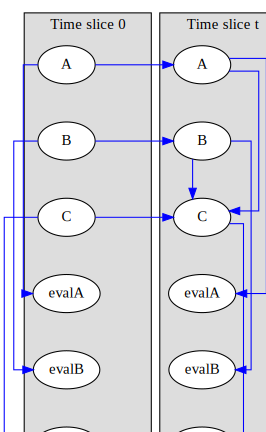

In [20]:
import pyAgrum.lib.dynamicBN as gdyn

# we initialize the network
dbn_str = ""

# we setup every node
for kc in domain_graph.get_knowledge_components():
    dbn_str += f"{kc.name}0" + "->" + f"{kc.name}t" + ";"
    dbn_str += f"{kc.name}0" + "->" + f"eval{kc.name}0" + ";"
    dbn_str += f"{kc.name}t" + "->" + f"eval{kc.name}t" + ";"

for kc in domain_graph.get_knowledge_components():
    kc_parents = domain_graph.link_model.get_parents(kc)
    for parent in kc_parents:
        #twotbn_str += f"{parent.name}_i-1" + "->" + f"{kc.name}_i-1" + ";"
        dbn_str += f"{parent.name}t" + "->" + f"{kc.name}t" + ";"

dbn = gum.fastBN(dbn_str[:-1])
gdyn.showTimeSlices(dbn)